<a href="https://colab.research.google.com/github/GagraniV/WiDS2023/blob/main/VJ_WiDS_Feb152023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
from random import random
import csv
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.style.use('ggplot')
import seaborn as sns
from datetime import datetime
from scipy import stats

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#to unmount
#drive.flush_and_unmount()
#Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", fo

Mounted at /content/drive


In [28]:
drive.flush_and_unmount()

In [11]:
trn_df= pd.read_csv('/content/drive/MyDrive/Kaggle2023/train_data.csv',nrows =5000)
tst_df= pd.read_csv('/content/drive/MyDrive/Kaggle2023/test_data.csv',nrows =5000)

In [12]:
#convert into pandas datetime object
trn_df.startdate = pd.to_datetime(trn_df.startdate)
tst_df.startdate = pd.to_datetime(tst_df.startdate)
# StartDate
print(min(trn_df.startdate), max(trn_df.startdate))

2014-09-01 00:00:00 2016-08-31 00:00:00


In [13]:
#Let's create a location feature from the lat/lon coordinates.
# Concatenate train and test data
scale =14
trn_df.loc[:,'lat']=round(trn_df.lat,scale)
trn_df.loc[:,'lon']=round(trn_df.lon,scale)

tst_df.loc[:,'lat']=round(tst_df.lat,scale)
tst_df.loc[:,'lon']=round(tst_df.lon,scale)
all_df = pd.concat([trn_df, tst_df], axis=0)

# Create new feature
all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
#display(all_df)

#print(f'{all_df.loc_group.nunique()} unique locations')

# Split back up
trn_df = all_df.iloc[:len(trn_df)]
tst_df = all_df.iloc[len(trn_df):]

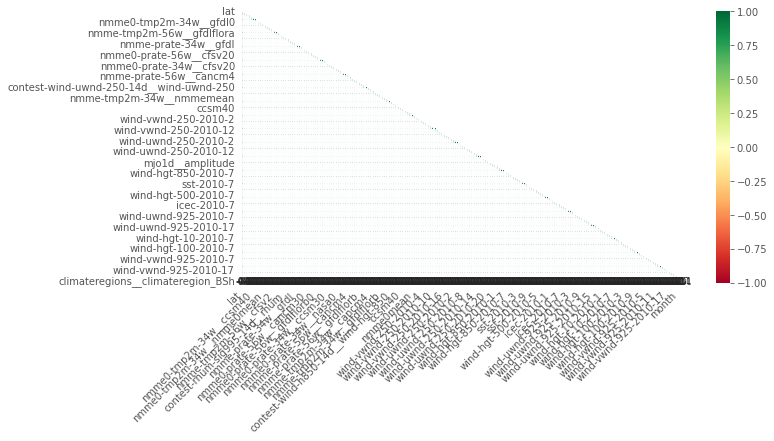

In [27]:
#trn_df = trn_df.dropna()
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html
import missingno as msno
# Trying to identify the correlation between the features which have missing values
msno.heatmap(trn_df, cmap="RdYlGn", figsize=(10,5), fontsize=10)

In [ ]:
#  ffill: propagate last valid observation forward to next valid backfill ) 
trn_df.fillna(method = 'ffill' , inplace = True)

In [14]:
# retrving year, month, and day
trn_df['year']=pd.DatetimeIndex(trn_df['startdate']).year 
trn_df['month']=pd.DatetimeIndex(trn_df['startdate']).month 
trn_df['day']=pd.DatetimeIndex(trn_df['startdate']).day

tst_df['year']=pd.DatetimeIndex(tst_df['startdate']).year 
tst_df['month']=pd.DatetimeIndex(tst_df['startdate']).month 
tst_df['day']=pd.DatetimeIndex(tst_df['startdate']).day

# drop the startdate column from training and test dataset

trn_df=trn_df.drop(['startdate'], axis=1)
trn_df=trn_df.drop(['index'], axis=1)

tst_df=tst_df.drop(['startdate'], axis=1)
tst_df=tst_df.drop(['index'], axis=1)

In [16]:
season_months = {
    12: 'Winter',
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall'
}

first_letter_desc = {
    'B': 'Dry climates (arid and semi-arid)',
    'C': 'Moist middle latitudes with mild winters (humid subtropical)',
    'D': 'Moist middle latitudes with cold winters (humid continental)'
}

trn_df['season'] = trn_df['month'].map(season_months)
trn_df['first_letter_desc'] = trn_df['climateregions__climateregion'].str[0].map(first_letter_desc)
tst_df['season'] = tst_df['month'].map(season_months)
tst_df['first_letter_desc'] = tst_df['climateregions__climateregion'].str[0].map(first_letter_desc)

In [17]:
#categorical varible encode

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe_results = ohe.fit_transform(trn_df.loc[:, ["climateregions__climateregion"]])
trn_df = pd.concat([trn_df,(pd.DataFrame(ohe_results, columns=ohe.get_feature_names_out()))],axis =1)
trn_df.head()

lat       lon  contest-pevpr-sfc-gauss-14d__pevpr  \
0  0.0  0.833333                              237.00   
1  0.0  0.833333                              228.90   
2  0.0  0.833333                              220.69   
3  0.0  0.833333                              225.28   
4  0.0  0.833333                              237.24   

   nmme0-tmp2m-34w__cancm30  nmme0-tmp2m-34w__cancm40  \
0                     29.02                     31.64   
1                     29.02                     31.64   
2                     29.02                     31.64   
3                     29.02                     31.64   
4                     29.02                     31.64   

   nmme0-tmp2m-34w__ccsm30  nmme0-tmp2m-34w__ccsm40  nmme0-tmp2m-34w__cfsv20  \
0                    29.57                    30.73                    29.71   
1                    29.57                    30.73                    29.71   
2                    29.57                    30.73                    29.71   
3                    29.57                    30.73                    29.71   
4                    29.57                    30.73                    29.71   

   nmme0-tmp2m-34w__gfdlflora0  nmme0-tmp2m-34w__gfdlflorb0  \
0                        31.52                        31.68   
1                        31.52                        31.68   
2                        31.52                        31.68   
3                        31.52                        31.68   
4                        31.52                        31.68   

   nmme0-tmp2m-34w__gfdl0  nmme0-tmp2m-34w__nasa0  nmme0-tmp2m-34w__nmme0mean  \
0                   30.56                   29.66                       30.46   
1                   30.56                   29.66                       30.46   
2                   30.56                   29.66                       30.46   
3                   30.56                   29.66                       30.46   
4                   30.56                   29.66                       30.46   

   contest-wind-h10-14d__wind-hgt-10  nmme-tmp2m-56w__cancm3  \
0                           31246.63                    28.3   
1                           31244.78                    28.3   
2                           31239.27                    28.3   
3                           31232.86                    28.3   
4                           31226.16                    28.3   

   nmme-tmp2m-56w__cancm4  nmme-tmp2m-56w__ccsm3  nmme-tmp2m-56w__ccsm4  \
0                   29.47                  27.13                  27.36   
1                   29.47                  27.13                  27.36   
2                   29.47                  27.13                  27.36   
3                   29.47                  27.13                  27.36   
4                   29.47                  27.13                  27.36   

   nmme-tmp2m-56w__cfsv2  nmme-tmp2m-56w__gfdl  nmme-tmp2m-56w__gfdlflora  \
0                  27.71                 28.25                       27.7   
1                  27.71                 28.25                       27.7   
2                  27.71                 28.25                       27.7   
3                  27.71                 28.25                       27.7   
4                  27.71                 28.25                       27.7   

   nmme-tmp2m-56w__gfdlflorb  nmme-tmp2m-56w__nasa  nmme-tmp2m-56w__nmmemean  \
0                      28.72                 28.38                     28.11   
1                      28.72                 28.38                     28.11   
2                      28.72                 28.38                     28.11   
3                      28.72                 28.38                     28.11   
4                      28.72                 28.38                     28.11   

   contest-rhum-sig995-14d__rhum  nmme-prate-34w__cancm3  \
0                          81.72                   25.33   
1                          82.56                   25.33   
2               

In [18]:
ohe_results = ohe.fit_transform(tst_df.loc[:, ["climateregions__climateregion"]])
tst_df = pd.concat([tst_df,(pd.DataFrame(ohe_results, columns=ohe.get_feature_names_out()))],axis =1)
tst_df.head()

lat       lon  contest-pevpr-sfc-gauss-14d__pevpr  \
0  0.0  0.833333                              339.88   
1  0.0  0.833333                              334.63   
2  0.0  0.833333                              337.83   
3  0.0  0.833333                              345.81   
4  0.0  0.833333                              357.39   

   nmme0-tmp2m-34w__cancm30  nmme0-tmp2m-34w__cancm40  \
0                     30.88                     30.92   
1                     30.88                     30.92   
2                     30.88                     30.92   
3                     30.88                     30.92   
4                     30.88                     30.92   

   nmme0-tmp2m-34w__ccsm30  nmme0-tmp2m-34w__ccsm40  nmme0-tmp2m-34w__cfsv20  \
0                    29.17                    31.02                    29.47   
1                    29.17                    31.02                    29.47   
2                    29.17                    31.02                    29.47   
3                    29.17                    31.02                    29.47   
4                    29.17                    31.02                    29.47   

   nmme0-tmp2m-34w__gfdlflora0  nmme0-tmp2m-34w__gfdlflorb0  \
0                        30.93                        30.54   
1                        30.93                        30.54   
2                        30.93                        30.54   
3                        30.93                        30.54   
4                        30.93                        30.54   

   nmme0-tmp2m-34w__gfdl0  nmme0-tmp2m-34w__nasa0  nmme0-tmp2m-34w__nmme0mean  \
0                   31.01                   29.39                       30.37   
1                   31.01                   29.39                       30.37   
2                   31.01                   29.39                       30.37   
3                   31.01                   29.39                       30.37   
4                   31.01                   29.39                       30.37   

   contest-wind-h10-14d__wind-hgt-10  nmme-tmp2m-56w__cancm3  \
0                           31233.02                   28.04   
1                           31230.63                   28.04   
2                           31225.26                   28.04   
3                           31220.87                   28.04   
4                           31214.54                   28.04   

   nmme-tmp2m-56w__cancm4  nmme-tmp2m-56w__ccsm3  nmme-tmp2m-56w__ccsm4  \
0                   29.58                  26.57                  28.13   
1                   29.58                  26.57                  28.13   
2                   29.58                  26.57                  28.13   
3                   29.58                  26.57                  28.13   
4                   29.58                  26.57                  28.13   

   nmme-tmp2m-56w__cfsv2  nmme-tmp2m-56w__gfdl  nmme-tmp2m-56w__gfdlflora  \
0                  27.56                 27.73                      26.82   
1                  27.56                 27.73                      26.82   
2                  27.56                 27.73                      26.82   
3                  27.56                 27.73                      26.82   
4                  27.56                 27.73                      26.82   

   nmme-tmp2m-56w__gfdlflorb  nmme-tmp2m-56w__nasa  nmme-tmp2m-56w__nmmemean  \
0                      27.91                 27.96                     27.81   
1                      27.91                 27.96                     27.81   
2                      27.91                 27.96                     27.81   
3                      27.91                 27.96                     27.81   
4                      27.91                 27.96                     27.81   

   contest-rhum-sig995-14d__rhum  nmme-prate-34w__cancm3  \
0                          72.04                   20.01   
1                          71.93                   20.01   
2               

In [25]:
irrelevant_cols = ['index', 'startdate','contest-tmp2m-14d__tmp2m', 'climateregions__climateregion','lat','lon']
features = [col for col in trn_df.columns if col not in irrelevant_cols]
X = trn_df[features]
X_test = tst_df[features]
y = trn_df['contest-tmp2m-14d__tmp2m']

In [26]:
corr_matrix = X.corr().abs()
corr_matrix

contest-pevpr-sfc-gauss-14d__pevpr  \
contest-pevpr-sfc-gauss-14d__pevpr                                  1.000000   
nmme0-tmp2m-34w__cancm30                                            0.492134   
nmme0-tmp2m-34w__cancm40                                            0.533729   
nmme0-tmp2m-34w__ccsm30                                             0.528747   
nmme0-tmp2m-34w__ccsm40                                             0.483360   
nmme0-tmp2m-34w__cfsv20                                             0.517200   
nmme0-tmp2m-34w__gfdlflora0                                         0.576250   
nmme0-tmp2m-34w__gfdlflorb0                                         0.570410   
nmme0-tmp2m-34w__gfdl0                                              0.554014   
nmme0-tmp2m-34w__nasa0                                              0.481678   
nmme0-tmp2m-34w__nmme0mean                                          0.534854   
contest-wind-h10-14d__wind-hgt-10                                   0.722107   
nmme-tmp2m-56w__cancm3                                              0.711133   
nmme-tmp2m-56w__cancm4                                              0.709615   
nmme-tmp2m-56w__ccsm3                                               0.709872   
nmme-tmp2m-56w__ccsm4                                               0.703143   
nmme-tmp2m-56w__cfsv2                                               0.671464   
nmme-tmp2m-56w__gfdl                                                0.703168   
nmme-tmp2m-56w__gfdlflora                                           0.734063   
nmme-tmp2m-56w__gfdlflorb                                           0.728035   
nmme-tmp2m-56w__nasa                                                0.642539   
nmme-tmp2m-56w__nmmemean                                            0.709327   
contest-rhum-sig995-14d__rhum                                       0.516492   
nmme-prate-34w__cancm3                                              0.200827   
nmme-prate-34w__cancm4                                              0.234215   
nmme-prate-34w__ccsm3                                               0.152915   
nmme-prate-34w__ccsm4                                               0.132996   
nmme-prate-34w__cfsv2                                               0.278150   
nmme-prate-34w__gfdl                                                0.564934   
nmme-prate-34w__gfdlflora                                           0.358794   
nmme-prate-34w__gfdlflorb                                           0.484183   
nmme-prate-34w__nasa                                                0.465283   
nmme-prate-34w__nmmemean                                            0.466069   
contest-wind-h100-14d__wind-hgt-100                                 0.676287   
nmme0-prate-56w__cancm30                                            0.300052   
nmme0-prate-56w__cancm40                                            0.229000   
nmme0-prate-56w__ccsm30                                             0.423115   
nmme0-prate-56w__ccsm40                                             0.202087   
nmme0-prate-56w__cfsv20                                             0.344272   
nmme0-prate-56w__gfdlflora0                                         0.309980   
nmme0-prate-56w__gfdlflorb0                                         0.223415   
nmme0-prate-56w__gfdl0                                              0.313305   
nmme0-prate-56w__nasa0                                              0.293565   
nmme0-prate-56w__nmme0mean                                          0.086738   
nmme0-prate-34w__cancm30                                            0.157949   
nmme0-prate-34w__cancm40                                            0.156435   
nmme0-prate-34w__ccsm30                                             0.321595   
nmme0-prate-34w__ccsm40                                             0.117256   
nmme0-prate-34w__cfsv20                                             0.260027   
nmme0-prate-34w__gfdlflora0               

In [ ]:
#https://www.educative.io/courses/hands-on-machine-learning-with-scikit-learn/myxq1v4mXxA
#Checking Correlation
def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

features_to_drop = identify_correlated(cc_train, .80)

In [ ]:
train_set = train_data[train_data.index <= '2016-03-31']
val_set = train_data[train_data.index > '2016-03-31'] # 2016-03-31
train_set.shape, val_set.shape

In [ ]:
cat_cols = [cname for cname in train_set.columns if train_set[cname].dtype not in ['int64', 'float64']]
print(cat_cols)

In [ ]:
# encoding Categorical data
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder() # Use ordinal encoder
train_set[cat_cols] = enc.fit_transform(train_set[cat_cols] )

In [ ]:
num_cols = [cname for cname in train_set.columns if train_set[cname].dtype in ['int64', 'float64']]

not_to_scale = {'contest-tmp2m-14d__tmp2m', 'climateregions__climateregion'} # I kept climateregions variable without scaling for future use
 
num_cols = [ele for ele in num_cols if ele not in not_to_scale]
data_num = train_set[num_cols

In [ ]:
# Encorded numerical variables 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
mmsc = MinMaxScaler()
train_set[num_cols] = sc.fit_transform(train_set[num_cols] )

In [ ]:
dtf = DatetimeFeatures(
        # the datetime variable
        variables ="index",
        
        # The features we want to create
        features_to_extract=[
            "year",
            "month",
        ]
)
# Extract the datetime features
train_set = dtf.fit_transform(train_set)

In [ ]:
# Create features that capture the cyclical representation

cyclicf = CyclicalFeatures(
            variables = ["year", "month"],
            drop_original = True,
)

train_set = cyclicf.fit_transform(train_set)
train_set["season"] = train_set.index.month%12 // 3 + 1

train_set[[ v for v in train_set.columns if "year" in v or "month" in v]]. head()

In [ ]:
# Adding Dummie Variables for the season
train_set = pd.get_dummies(data=train_set, columns=['season'])

In [ ]:
# Adding Dummie Variables for the climateregions
train_set = pd.get_dummies(data=train_set, columns=['climateregions__climateregion'])

In [ ]:
#Prepare the Data for Machine Learning Algorithms
X_train = train_set.drop("contest-tmp2m-14d__tmp2m", axis=1).copy(deep=True)
y_train = train_set["contest-tmp2m-14d__tmp2m"].copy(deep=True)
X_train.shape, y_train.shape


In [ ]:
#Validation Data Preparation
# Get the same shape as train set by dropping the less useful features 
val_set = val_set.drop(to_drop, axis=1)

In [ ]:
# encoding Categorical data
val_set[cat_cols] = enc.transform(val_set[cat_cols] )

In [ ]:
val_num_cols = [cname for cname in val_set.columns if val_set[cname].dtype in ['int64', 'float64']]

not_to_scale = {'contest-tmp2m-14d__tmp2m','climateregions__climateregion'}
 
val_num_cols = [ele for ele in val_num_cols  if ele not in not_to_scale]
val_data_num = val_set[val_num_cols]

In [ ]:
# https://www.kaggle.com/code/anjanagunathilake/wids-datathon-2023-extreme-weather-forecasts
#Scaling numerical data
val_set[val_num_cols ] = sc.transform(val_set[val_num_cols] )